# 데모

## 라이브러리 import 및  설정

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [8]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [13]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 42

In [14]:
algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [15]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [16]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

## Stratified K-Fold Cross Validation

In [52]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

## LightGBM 모델 학습

In [53]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=3000,
                             num_leaves=128,
                             learning_rate=0.02,
                             min_child_samples=10,
                             subsample=.9,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=0,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.954439
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.924677
[3]	valid_0's multi_logloss: 0.896569
[4]	valid_0's multi_logloss: 0.869921
[5]	valid_0's multi_logloss: 0.844628
[6]	valid_0's multi_logloss: 0.82058
[7]	valid_0's multi_logloss: 0.797649
[8]	valid_0's multi_logloss: 0.775788
[9]	valid_0's multi_logloss: 0.754918
[10]	valid_0's multi_logloss: 0.734964
[11]	valid_0's multi_logloss: 0.715867
[12]	valid_0's multi_logloss: 0.697578
[13]	valid_0's multi_logloss: 0.680058
[14]	valid_0's multi_logloss: 0.663237
[15]	valid_0's multi_logloss: 0.647099
[16]	valid_0's multi_logloss: 0.631598
[17]	valid_0's multi_logloss: 0.616692
[18]	valid_0's multi_logloss: 0.602354
[19]	valid_0's multi_logloss: 0.588558
[20]	valid_0's multi_logloss: 0.575287
[21]	valid_0's multi_logloss: 0.562498
[22]	valid_0's multi_logloss: 0.550183
[23]	valid_0's multi_logloss: 0.538302
[24]	valid_0's multi_loglos

[214]	valid_0's multi_logloss: 0.163379
[215]	valid_0's multi_logloss: 0.163305
[216]	valid_0's multi_logloss: 0.163229
[217]	valid_0's multi_logloss: 0.163152
[218]	valid_0's multi_logloss: 0.163068
[219]	valid_0's multi_logloss: 0.162995
[220]	valid_0's multi_logloss: 0.162923
[221]	valid_0's multi_logloss: 0.16285
[222]	valid_0's multi_logloss: 0.16278
[223]	valid_0's multi_logloss: 0.162713
[224]	valid_0's multi_logloss: 0.162648
[225]	valid_0's multi_logloss: 0.162584
[226]	valid_0's multi_logloss: 0.162521
[227]	valid_0's multi_logloss: 0.162461
[228]	valid_0's multi_logloss: 0.162402
[229]	valid_0's multi_logloss: 0.162348
[230]	valid_0's multi_logloss: 0.162287
[231]	valid_0's multi_logloss: 0.162233
[232]	valid_0's multi_logloss: 0.162174
[233]	valid_0's multi_logloss: 0.162114
[234]	valid_0's multi_logloss: 0.162066
[235]	valid_0's multi_logloss: 0.162015
[236]	valid_0's multi_logloss: 0.161958
[237]	valid_0's multi_logloss: 0.161914
[238]	valid_0's multi_logloss: 0.161863
[2

[7]	valid_0's multi_logloss: 0.797579
[8]	valid_0's multi_logloss: 0.775725
[9]	valid_0's multi_logloss: 0.75486
[10]	valid_0's multi_logloss: 0.734916
[11]	valid_0's multi_logloss: 0.71584
[12]	valid_0's multi_logloss: 0.69754
[13]	valid_0's multi_logloss: 0.680017
[14]	valid_0's multi_logloss: 0.663213
[15]	valid_0's multi_logloss: 0.647064
[16]	valid_0's multi_logloss: 0.631567
[17]	valid_0's multi_logloss: 0.61666
[18]	valid_0's multi_logloss: 0.602331
[19]	valid_0's multi_logloss: 0.588556
[20]	valid_0's multi_logloss: 0.575294
[21]	valid_0's multi_logloss: 0.562519
[22]	valid_0's multi_logloss: 0.550219
[23]	valid_0's multi_logloss: 0.538348
[24]	valid_0's multi_logloss: 0.526912
[25]	valid_0's multi_logloss: 0.515877
[26]	valid_0's multi_logloss: 0.505213
[27]	valid_0's multi_logloss: 0.494929
[28]	valid_0's multi_logloss: 0.485005
[29]	valid_0's multi_logloss: 0.47542
[30]	valid_0's multi_logloss: 0.466165
[31]	valid_0's multi_logloss: 0.45721
[32]	valid_0's multi_logloss: 0.44

[218]	valid_0's multi_logloss: 0.163545
[219]	valid_0's multi_logloss: 0.163475
[220]	valid_0's multi_logloss: 0.163408
[221]	valid_0's multi_logloss: 0.163334
[222]	valid_0's multi_logloss: 0.163256
[223]	valid_0's multi_logloss: 0.163187
[224]	valid_0's multi_logloss: 0.163114
[225]	valid_0's multi_logloss: 0.163046
[226]	valid_0's multi_logloss: 0.162972
[227]	valid_0's multi_logloss: 0.16291
[228]	valid_0's multi_logloss: 0.162847
[229]	valid_0's multi_logloss: 0.162789
[230]	valid_0's multi_logloss: 0.16273
[231]	valid_0's multi_logloss: 0.162666
[232]	valid_0's multi_logloss: 0.162604
[233]	valid_0's multi_logloss: 0.162543
[234]	valid_0's multi_logloss: 0.162491
[235]	valid_0's multi_logloss: 0.162435
[236]	valid_0's multi_logloss: 0.162388
[237]	valid_0's multi_logloss: 0.162338
[238]	valid_0's multi_logloss: 0.162289
[239]	valid_0's multi_logloss: 0.162231
[240]	valid_0's multi_logloss: 0.162179
[241]	valid_0's multi_logloss: 0.16214
[242]	valid_0's multi_logloss: 0.162089
[24

[18]	valid_0's multi_logloss: 0.603351
[19]	valid_0's multi_logloss: 0.589599
[20]	valid_0's multi_logloss: 0.576355
[21]	valid_0's multi_logloss: 0.563585
[22]	valid_0's multi_logloss: 0.551292
[23]	valid_0's multi_logloss: 0.53944
[24]	valid_0's multi_logloss: 0.528015
[25]	valid_0's multi_logloss: 0.516991
[26]	valid_0's multi_logloss: 0.506353
[27]	valid_0's multi_logloss: 0.496081
[28]	valid_0's multi_logloss: 0.486168
[29]	valid_0's multi_logloss: 0.47659
[30]	valid_0's multi_logloss: 0.467337
[31]	valid_0's multi_logloss: 0.458403
[32]	valid_0's multi_logloss: 0.449757
[33]	valid_0's multi_logloss: 0.441394
[34]	valid_0's multi_logloss: 0.433324
[35]	valid_0's multi_logloss: 0.425502
[36]	valid_0's multi_logloss: 0.417933
[37]	valid_0's multi_logloss: 0.410605
[38]	valid_0's multi_logloss: 0.403526
[39]	valid_0's multi_logloss: 0.39668
[40]	valid_0's multi_logloss: 0.390036
[41]	valid_0's multi_logloss: 0.383608
[42]	valid_0's multi_logloss: 0.377379
[43]	valid_0's multi_logloss

[227]	valid_0's multi_logloss: 0.164343
[228]	valid_0's multi_logloss: 0.164286
[229]	valid_0's multi_logloss: 0.164229
[230]	valid_0's multi_logloss: 0.16417
[231]	valid_0's multi_logloss: 0.164116
[232]	valid_0's multi_logloss: 0.164062
[233]	valid_0's multi_logloss: 0.164001
[234]	valid_0's multi_logloss: 0.163944
[235]	valid_0's multi_logloss: 0.163889
[236]	valid_0's multi_logloss: 0.16384
[237]	valid_0's multi_logloss: 0.163794
[238]	valid_0's multi_logloss: 0.163736
[239]	valid_0's multi_logloss: 0.163692
[240]	valid_0's multi_logloss: 0.163648
[241]	valid_0's multi_logloss: 0.163605
[242]	valid_0's multi_logloss: 0.163553
[243]	valid_0's multi_logloss: 0.163509
[244]	valid_0's multi_logloss: 0.163466
[245]	valid_0's multi_logloss: 0.163416
[246]	valid_0's multi_logloss: 0.163381
[247]	valid_0's multi_logloss: 0.163329
[248]	valid_0's multi_logloss: 0.163292
[249]	valid_0's multi_logloss: 0.163253
[250]	valid_0's multi_logloss: 0.163212
[251]	valid_0's multi_logloss: 0.163181
[2

[22]	valid_0's multi_logloss: 0.549928
[23]	valid_0's multi_logloss: 0.538048
[24]	valid_0's multi_logloss: 0.526582
[25]	valid_0's multi_logloss: 0.515533
[26]	valid_0's multi_logloss: 0.50486
[27]	valid_0's multi_logloss: 0.494569
[28]	valid_0's multi_logloss: 0.484627
[29]	valid_0's multi_logloss: 0.47503
[30]	valid_0's multi_logloss: 0.465754
[31]	valid_0's multi_logloss: 0.456799
[32]	valid_0's multi_logloss: 0.448143
[33]	valid_0's multi_logloss: 0.439784
[34]	valid_0's multi_logloss: 0.431689
[35]	valid_0's multi_logloss: 0.423858
[36]	valid_0's multi_logloss: 0.416274
[37]	valid_0's multi_logloss: 0.408945
[38]	valid_0's multi_logloss: 0.401841
[39]	valid_0's multi_logloss: 0.394972
[40]	valid_0's multi_logloss: 0.388308
[41]	valid_0's multi_logloss: 0.381871
[42]	valid_0's multi_logloss: 0.375627
[43]	valid_0's multi_logloss: 0.369572
[44]	valid_0's multi_logloss: 0.363719
[45]	valid_0's multi_logloss: 0.358034
[46]	valid_0's multi_logloss: 0.352539
[47]	valid_0's multi_loglos

[234]	valid_0's multi_logloss: 0.16136
[235]	valid_0's multi_logloss: 0.161308
[236]	valid_0's multi_logloss: 0.161259
[237]	valid_0's multi_logloss: 0.161204
[238]	valid_0's multi_logloss: 0.161157
[239]	valid_0's multi_logloss: 0.161108
[240]	valid_0's multi_logloss: 0.161061
[241]	valid_0's multi_logloss: 0.161018
[242]	valid_0's multi_logloss: 0.160971
[243]	valid_0's multi_logloss: 0.160924
[244]	valid_0's multi_logloss: 0.160877
[245]	valid_0's multi_logloss: 0.160839
[246]	valid_0's multi_logloss: 0.160799
[247]	valid_0's multi_logloss: 0.160763
[248]	valid_0's multi_logloss: 0.160725
[249]	valid_0's multi_logloss: 0.160679
[250]	valid_0's multi_logloss: 0.16064
[251]	valid_0's multi_logloss: 0.160604
[252]	valid_0's multi_logloss: 0.160565
[253]	valid_0's multi_logloss: 0.160533
[254]	valid_0's multi_logloss: 0.160499
[255]	valid_0's multi_logloss: 0.160466
[256]	valid_0's multi_logloss: 0.160425
[257]	valid_0's multi_logloss: 0.160396
[258]	valid_0's multi_logloss: 0.160366
[2

[65]	valid_0's multi_logloss: 0.274105
[66]	valid_0's multi_logloss: 0.271075
[67]	valid_0's multi_logloss: 0.268146
[68]	valid_0's multi_logloss: 0.265305
[69]	valid_0's multi_logloss: 0.262535
[70]	valid_0's multi_logloss: 0.259847
[71]	valid_0's multi_logloss: 0.25723
[72]	valid_0's multi_logloss: 0.254703
[73]	valid_0's multi_logloss: 0.252233
[74]	valid_0's multi_logloss: 0.249844
[75]	valid_0's multi_logloss: 0.24751
[76]	valid_0's multi_logloss: 0.245246
[77]	valid_0's multi_logloss: 0.243038
[78]	valid_0's multi_logloss: 0.240914
[79]	valid_0's multi_logloss: 0.23883
[80]	valid_0's multi_logloss: 0.236802
[81]	valid_0's multi_logloss: 0.234837
[82]	valid_0's multi_logloss: 0.232928
[83]	valid_0's multi_logloss: 0.23106
[84]	valid_0's multi_logloss: 0.229263
[85]	valid_0's multi_logloss: 0.227508
[86]	valid_0's multi_logloss: 0.225794
[87]	valid_0's multi_logloss: 0.224132
[88]	valid_0's multi_logloss: 0.222511
[89]	valid_0's multi_logloss: 0.220937
[90]	valid_0's multi_logloss:

[275]	valid_0's multi_logloss: 0.159929
[276]	valid_0's multi_logloss: 0.159903
[277]	valid_0's multi_logloss: 0.159882
[278]	valid_0's multi_logloss: 0.159859
[279]	valid_0's multi_logloss: 0.159835
[280]	valid_0's multi_logloss: 0.159812
[281]	valid_0's multi_logloss: 0.159794
[282]	valid_0's multi_logloss: 0.15978
[283]	valid_0's multi_logloss: 0.159764
[284]	valid_0's multi_logloss: 0.15974
[285]	valid_0's multi_logloss: 0.159727
[286]	valid_0's multi_logloss: 0.159705
[287]	valid_0's multi_logloss: 0.159685
[288]	valid_0's multi_logloss: 0.159678
[289]	valid_0's multi_logloss: 0.159663
[290]	valid_0's multi_logloss: 0.159644
[291]	valid_0's multi_logloss: 0.159622
[292]	valid_0's multi_logloss: 0.159608
[293]	valid_0's multi_logloss: 0.159592
[294]	valid_0's multi_logloss: 0.159577
[295]	valid_0's multi_logloss: 0.159566
[296]	valid_0's multi_logloss: 0.159548
[297]	valid_0's multi_logloss: 0.159532
[298]	valid_0's multi_logloss: 0.159514
[299]	valid_0's multi_logloss: 0.159509
[3

[80]	valid_0's multi_logloss: 0.238071
[81]	valid_0's multi_logloss: 0.236119
[82]	valid_0's multi_logloss: 0.234219
[83]	valid_0's multi_logloss: 0.232366
[84]	valid_0's multi_logloss: 0.230559
[85]	valid_0's multi_logloss: 0.228807
[86]	valid_0's multi_logloss: 0.227102
[87]	valid_0's multi_logloss: 0.225437
[88]	valid_0's multi_logloss: 0.22383
[89]	valid_0's multi_logloss: 0.222262
[90]	valid_0's multi_logloss: 0.220734
[91]	valid_0's multi_logloss: 0.219245
[92]	valid_0's multi_logloss: 0.21779
[93]	valid_0's multi_logloss: 0.21639
[94]	valid_0's multi_logloss: 0.215018
[95]	valid_0's multi_logloss: 0.213684
[96]	valid_0's multi_logloss: 0.212384
[97]	valid_0's multi_logloss: 0.211113
[98]	valid_0's multi_logloss: 0.209887
[99]	valid_0's multi_logloss: 0.208691
[100]	valid_0's multi_logloss: 0.207525
[101]	valid_0's multi_logloss: 0.206395
[102]	valid_0's multi_logloss: 0.205287
[103]	valid_0's multi_logloss: 0.204209
[104]	valid_0's multi_logloss: 0.203159
[105]	valid_0's multi_l

[288]	valid_0's multi_logloss: 0.161182
[289]	valid_0's multi_logloss: 0.161163
[290]	valid_0's multi_logloss: 0.161152
[291]	valid_0's multi_logloss: 0.16113
[292]	valid_0's multi_logloss: 0.161117
[293]	valid_0's multi_logloss: 0.161094
[294]	valid_0's multi_logloss: 0.161083
[295]	valid_0's multi_logloss: 0.161067
[296]	valid_0's multi_logloss: 0.161057
[297]	valid_0's multi_logloss: 0.161048
[298]	valid_0's multi_logloss: 0.161035
[299]	valid_0's multi_logloss: 0.161014
[300]	valid_0's multi_logloss: 0.160997
[301]	valid_0's multi_logloss: 0.160991
[302]	valid_0's multi_logloss: 0.160976
[303]	valid_0's multi_logloss: 0.160967
[304]	valid_0's multi_logloss: 0.160955
[305]	valid_0's multi_logloss: 0.160947
[306]	valid_0's multi_logloss: 0.16094
[307]	valid_0's multi_logloss: 0.16093
[308]	valid_0's multi_logloss: 0.160925
[309]	valid_0's multi_logloss: 0.16091
[310]	valid_0's multi_logloss: 0.160898
[311]	valid_0's multi_logloss: 0.160881
[312]	valid_0's multi_logloss: 0.160876
[313

[117]	valid_0's multi_logloss: 0.190037
[118]	valid_0's multi_logloss: 0.189314
[119]	valid_0's multi_logloss: 0.188617
[120]	valid_0's multi_logloss: 0.187927
[121]	valid_0's multi_logloss: 0.187246
[122]	valid_0's multi_logloss: 0.186593
[123]	valid_0's multi_logloss: 0.185941
[124]	valid_0's multi_logloss: 0.18531
[125]	valid_0's multi_logloss: 0.184704
[126]	valid_0's multi_logloss: 0.184108
[127]	valid_0's multi_logloss: 0.183527
[128]	valid_0's multi_logloss: 0.182956
[129]	valid_0's multi_logloss: 0.18241
[130]	valid_0's multi_logloss: 0.18187
[131]	valid_0's multi_logloss: 0.181347
[132]	valid_0's multi_logloss: 0.18084
[133]	valid_0's multi_logloss: 0.180333
[134]	valid_0's multi_logloss: 0.17985
[135]	valid_0's multi_logloss: 0.179378
[136]	valid_0's multi_logloss: 0.178909
[137]	valid_0's multi_logloss: 0.178451
[138]	valid_0's multi_logloss: 0.178005
[139]	valid_0's multi_logloss: 0.177575
[140]	valid_0's multi_logloss: 0.177147
[141]	valid_0's multi_logloss: 0.176741
[142]

[322]	valid_0's multi_logloss: 0.158736
[323]	valid_0's multi_logloss: 0.158729
[324]	valid_0's multi_logloss: 0.158714
[325]	valid_0's multi_logloss: 0.158708
[326]	valid_0's multi_logloss: 0.158705
[327]	valid_0's multi_logloss: 0.158702
[328]	valid_0's multi_logloss: 0.158697
[329]	valid_0's multi_logloss: 0.158682
[330]	valid_0's multi_logloss: 0.158673
[331]	valid_0's multi_logloss: 0.15867
[332]	valid_0's multi_logloss: 0.158664
[333]	valid_0's multi_logloss: 0.158662
[334]	valid_0's multi_logloss: 0.158651
[335]	valid_0's multi_logloss: 0.158648
[336]	valid_0's multi_logloss: 0.158641
[337]	valid_0's multi_logloss: 0.158635
[338]	valid_0's multi_logloss: 0.158631
[339]	valid_0's multi_logloss: 0.158624
[340]	valid_0's multi_logloss: 0.158619
[341]	valid_0's multi_logloss: 0.158611
[342]	valid_0's multi_logloss: 0.158609
[343]	valid_0's multi_logloss: 0.158607
[344]	valid_0's multi_logloss: 0.158602
[345]	valid_0's multi_logloss: 0.158599
[346]	valid_0's multi_logloss: 0.158599
[

In [54]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3509%


In [55]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [56]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [57]:
clf.coef_.shape

AttributeError: 'LGBMClassifier' object has no attribute 'coef_'

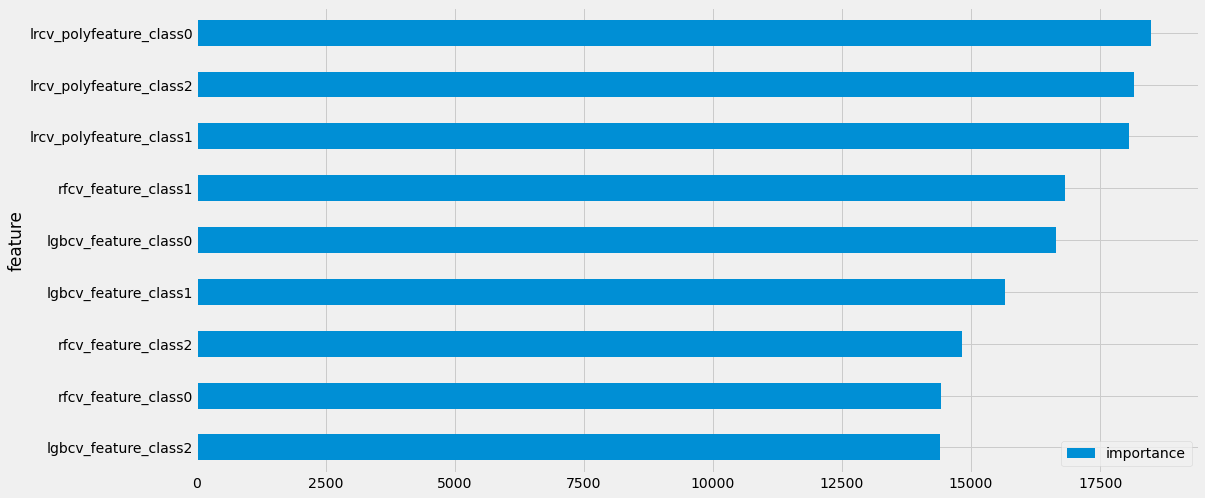

In [58]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [59]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [60]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [61]:
sub[target_col].value_counts()

2    40878
0    29983
1     9139
Name: class, dtype: int64

In [62]:
sub.to_csv(sub_file)